# Big Data Project, Group J: Thomas Harris, Matthew Conway and Sam Turnock

# Purpose

This script is the first of two python scripts that use machine learning methods to conduct regression analysis on NFL player passing yards. 

The entire preliminary data manipulation is done through an R project

### Structure

__Set up__
* Import packages and functions
* Read in data
* Replace NAs
* Visualise some data with
    * regression pair plots
    * histograms
    
__Regression Analysis__
* Run preliminary regression analysis on the full data frame
* Compare in and out-of-sample results
* Use shrinkage methods to improve regression performance
    * Ridge regression
    * Optimising Ridge regression with cross-validation
    * Lasso regression
    * Optimising Lasso regression with cross-validation
* Evaluate penalised coefficients


## Set up

### Import packages

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

### Read in data

Read in the core NFL data frame. This is derived from a range of data sets. At the end of the data production, the data frame is filtered to only include data for weeks 3 - 16 of the season. The season average variable is also lagged by 2 games to avoid any relationship with the previous week's passing yards.This is done to reduce multicollinearity between historical averages and previous week variables. 

In [44]:
# Read in the data
NFL_df = pd.read_csv(r'C:\\Users\\tomam\\OneDrive\\Documents\\QMUL\\Group projects\\Big data\\NFL_Data_Project\\NFL_Past_Wk2.csv')

For data definitions see the project annex

In [45]:
print(NFL_df.columns)

Index(['Player', 'Date', 'Age', 'Team', 'Home', 'Opponent', 'Game_number',
       'Attempted_Passes', 'P_Yds', 'Season', 'Prev_Wk_P_Yds', 'Seas_Av_P_Yds',
       'Prev_Seas_Av_P_Yds', 'Prev_Seas_Av_P_Atts', 'Prev_Seas_Comp_Perc',
       'Opp_Prev_Seas_Conc_P_Yds', 'Opp_Prev_Seas_Conc_P_Atts',
       'Opp_Prev_Seas_Conc_R_Yds', 'Opp_Prev_Seas_Conc_R_Atts',
       'Opp_Seas_Av_P_Yds', 'Opp_Seas_Av_P_Atts', 'Opp_Prev_Wk_P_Yds',
       'Prev_Wk_R_Yds', 'Seas_Av_R_Yds',
       'Previous_Week_To_Date_This_Season_Average_Rushing_Yards',
       'Prev_Vs_Opp_P_Yds', 'Prev_Vs_Opp_P_Atts', 'Precipitation', 'WindSpeed',
       'Temperature', 'Outdoors', 'Over_B_Line', 'Under_B_Line', 'mean_line'],
      dtype='object')


### Replace NAs
There are lots of NA values in the data. Some of these are a result of missing values in the raw data, some are induced by the manipulation which means they should be treated differently. We have three options for how to do address the missing values - either removing those observations, remove those columns, replace the data with the mean.

The explanatory variables with NAs are

In [4]:
# Prev_Seas_Av_P_Yds                                         229
# Prev_Seas_Av_P_Atts                                        229
# Prev_Seas_Comp_Perc                                        229
# Prev_Vs_Opp_P_Yds                                          727
# Prev_Vs_Opp_P_Atts                                         727
# Precipitation                                              283

In [46]:
NFL_df.isna().sum()   

Player                                                       0
Date                                                         0
Age                                                          0
Team                                                         0
Home                                                         0
Opponent                                                     0
Game_number                                                  0
Attempted_Passes                                             0
P_Yds                                                        0
Season                                                       0
Prev_Wk_P_Yds                                                0
Seas_Av_P_Yds                                                0
Prev_Seas_Av_P_Yds                                         237
Prev_Seas_Av_P_Atts                                        237
Prev_Seas_Comp_Perc                                        237
Opp_Prev_Seas_Conc_P_Yds                               

Firstly, for precipitation we define a mean value for outdoors and replace NAs with the mean. For indoors we replace NAs with 0, becuase it does not rain indoors as it doesn't rain.

In [47]:
outdoors_rows = NFL_df['Outdoors'] == 1
mean_outdoors_precip = NFL_df.loc[outdoors_rows, 'Precipitation'].mean()

for i in NFL_df['Outdoors']:
    if i == 1:
        NFL_df['Precipitation'].fillna(value = mean_outdoors_precip, inplace = True)
    else:
        NFL_df['Precipitation'].fillna(value = 0, inplace = True)

Secondly, for previous matches vs the opponent, we replace these data with the column mean. A player might have no data here because either a) we have not included enough historical data; or b) the player is new to the league and they have not faced this opponent yet. 

In [48]:
avg_1 = NFL_df['Prev_Vs_Opp_P_Yds'].mean()
NFL_df['Prev_Vs_Opp_P_Yds'].fillna(value = avg_1, inplace = True)

avg_2 = NFL_df['Prev_Vs_Opp_P_Atts'].mean()
NFL_df['Prev_Vs_Opp_P_Atts'].fillna(value = avg_2, inplace = True)

Finally, we remove any residual missing values

In [49]:
NFL_df.dropna(axis = 0, how = 'any', inplace = True)

Now we can see whether there are still any NAs in the data.

In [53]:
NFL_df.isna().sum()

Player                                                     0
Date                                                       0
Age                                                        0
Team                                                       0
Home                                                       0
Opponent                                                   0
Game_number                                                0
Attempted_Passes                                           0
P_Yds                                                      0
Season                                                     0
Prev_Wk_P_Yds                                              0
Seas_Av_P_Yds                                              0
Prev_Seas_Av_P_Yds                                         0
Prev_Seas_Av_P_Atts                                        0
Prev_Seas_Comp_Perc                                        0
Opp_Prev_Seas_Conc_P_Yds                                   0
Opp_Prev_Seas_Conc_P_Att

Count the number of rows in the final data frame.

In [52]:
row_count = NFL_df.shape[0]
print(row_count)

1134


### Data types

We want to make sure the data are in the right format. 

In [10]:
NFL_df.dtypes

Player                        object
Date                          object
Age                          float64
Team                          object
Home                           int64
Opponent                      object
Game_number                    int64
Attempted_Passes               int64
P_Yds                          int64
Season                        object
Prev_Wk_P_Yds                  int64
Seas_Av_P_Yds                  int64
Prev_Seas_Av_P_Yds           float64
Prev_Seas_Av_P_Atts          float64
Prev_Seas_Comp_Perc          float64
Opp_Prev_Seas_Conc_P_Yds       int64
Opp_Prev_Seas_Conc_P_Atts      int64
Opp_Prev_Seas_Conc_R_Yds       int64
Opp_Prev_Seas_Conc_R_Atts      int64
Opp_Seas_Av_P_Yds              int64
Opp_Seas_Av_P_Atts             int64
Opp_Prev_Wk_P_Yds              int64
Prev_Wk_R_Yds                  int64
Seas_Av_R_Yds                  int64
Prev_Vs_Opp_P_Yds            float64
Prev_Vs_Opp_P_Atts           float64
Precipitation                float64
W

## Plotting the data

We plot the data to gauge any initially visible correlations.

Some of the plots have some vertical data clusters - these are where we have filled NAs with the mean.

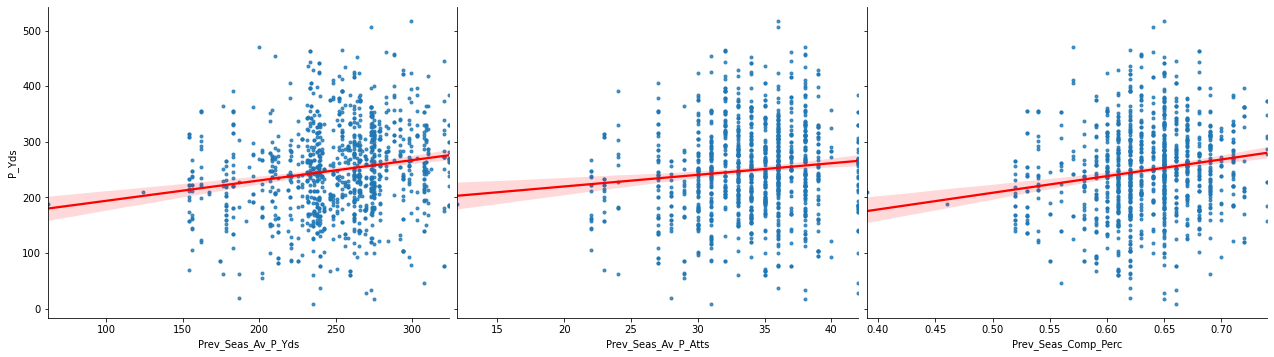

In [11]:
prev_seas_pp = sns.pairplot(data=NFL_df,
                  y_vars=['P_Yds'],
                  x_vars=['Prev_Seas_Av_P_Yds', 'Prev_Seas_Av_P_Atts', 'Prev_Seas_Comp_Perc'],
                           kind="reg",
                           plot_kws={'line_kws':{'color':'red'}},
                           aspect=1.2,
                           height=5,
                            markers=".")

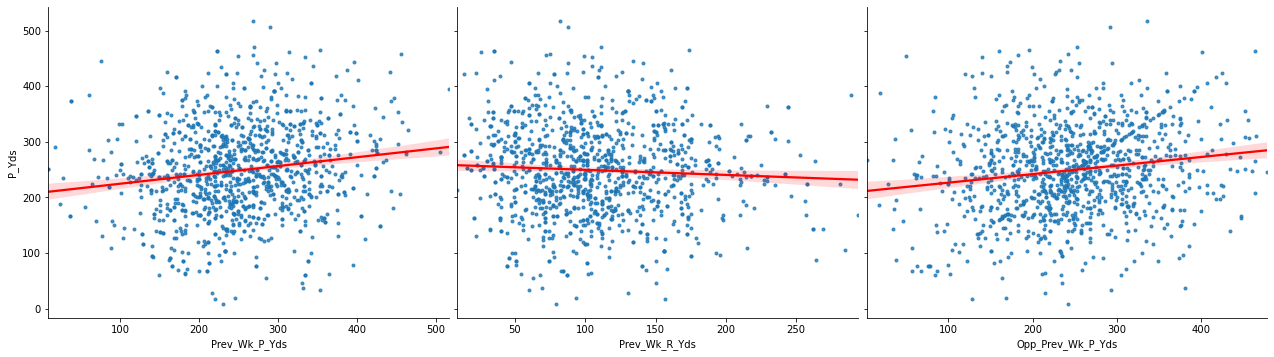

In [12]:
prev_week_pp = sns.pairplot(data=NFL_df,
                  y_vars=['P_Yds'],
                  x_vars=['Prev_Wk_P_Yds', 'Prev_Wk_R_Yds', 'Opp_Prev_Wk_P_Yds'],
                           kind="reg",
                            plot_kws={'line_kws':{'color':'red'}},
                            aspect=1.2,
                            height=5,
                            markers=".")

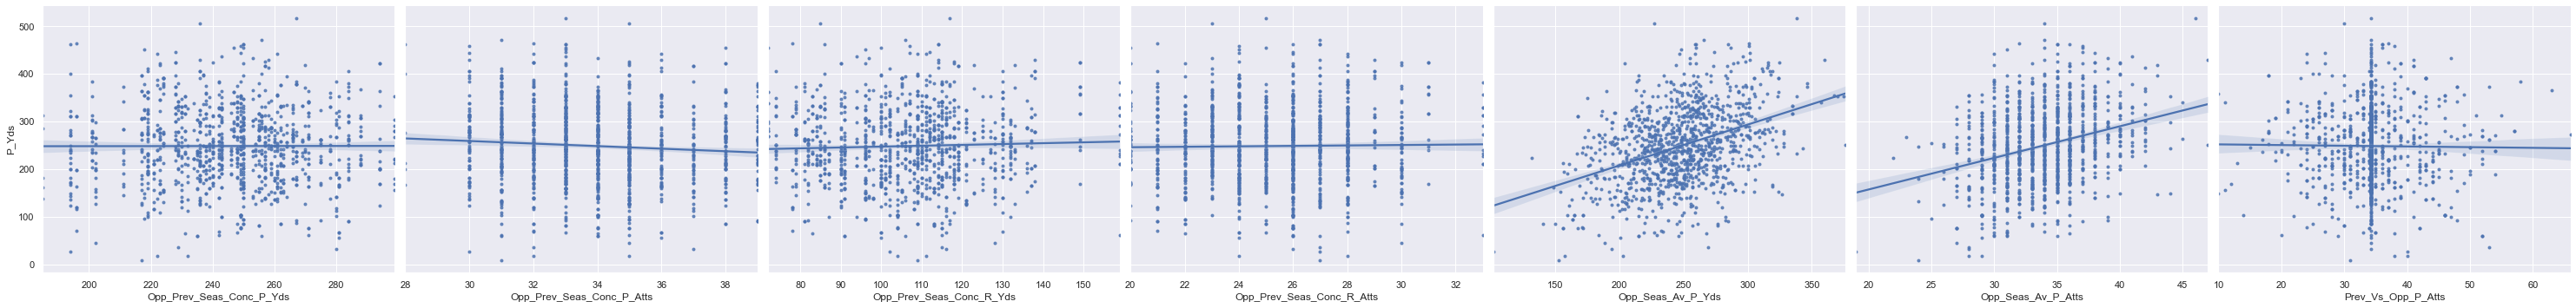

In [13]:
sns.set_theme(style="darkgrid")
Opponent_pp = sns.pairplot(data=NFL_df,
                  y_vars=['P_Yds'],
                  x_vars=['Opp_Prev_Seas_Conc_P_Yds', 'Opp_Prev_Seas_Conc_P_Atts',
       'Opp_Prev_Seas_Conc_R_Yds', 'Opp_Prev_Seas_Conc_R_Atts',
       'Opp_Seas_Av_P_Yds', 'Opp_Seas_Av_P_Atts', 'Prev_Vs_Opp_P_Atts'],
                           kind = "reg",
                           aspect=1.2,
                           height=5,
                           markers=".")
                           

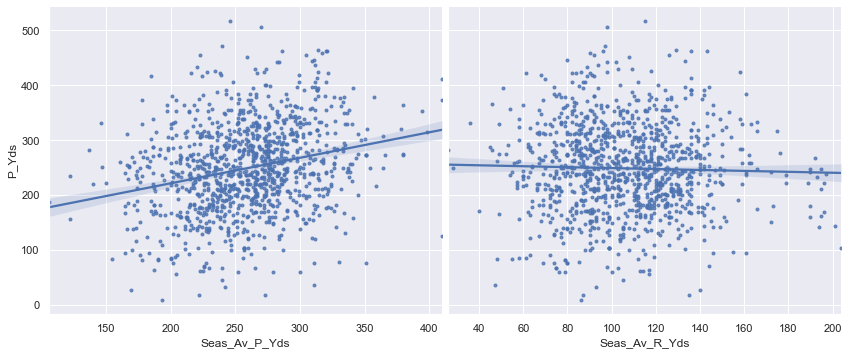

In [14]:
Current_Seas_pp = sns.pairplot(data=NFL_df,
                  y_vars=['P_Yds'],
                  x_vars=['Seas_Av_P_Yds', 'Seas_Av_R_Yds'],
                               kind = "reg",
                               
                               aspect=1.2,
                               height=5,
                               markers=".")

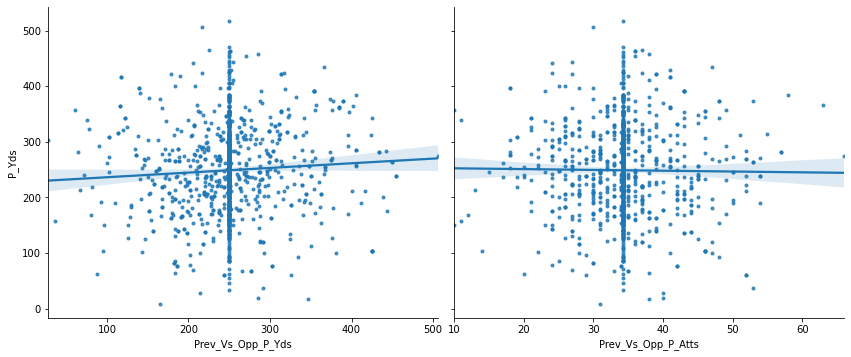

In [20]:
Current_Seas_Opp_pp = sns.pairplot(data=NFL_df,
                  y_vars=['P_Yds'],
                  x_vars=['Prev_Vs_Opp_P_Yds', 'Prev_Vs_Opp_P_Atts'],
                               kind = "reg",
                             
                               aspect=1.2,
                               height=5,
                               markers=".")

# Key graphs: those included in the presentation

Below are the 6 graphs included in the presentation. They show a sloped regression line between the variable and P_Yds

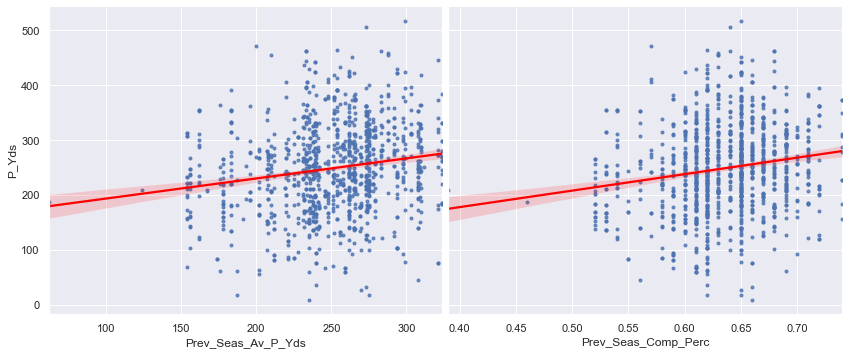

In [16]:
Key_Graphs_1 = sns.pairplot(data=NFL_df,
                  y_vars=['P_Yds'],
                  x_vars=['Prev_Seas_Av_P_Yds', 'Prev_Seas_Comp_Perc'],
                           kind="reg",
                           plot_kws={'line_kws':{'color':'red'}},
                           aspect=1.2,
                           height=5,
                            markers=".")

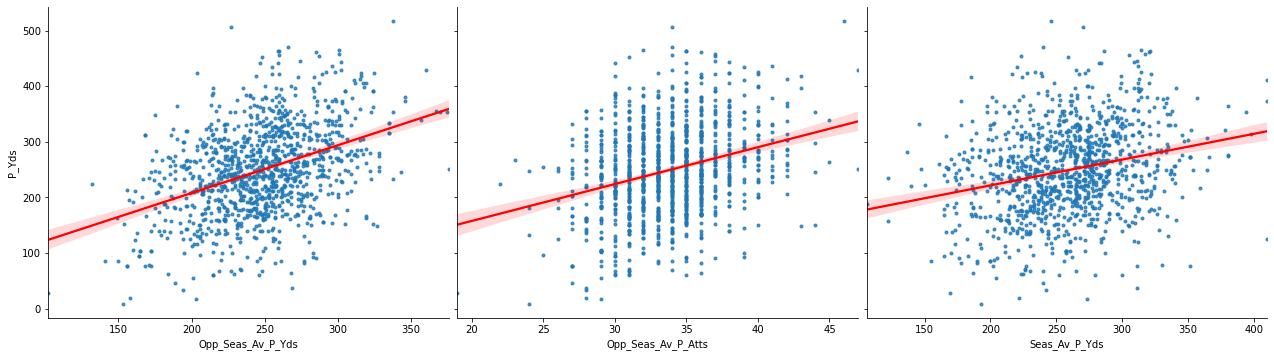

In [54]:
Key_Graphs_2 = sns.pairplot(data=NFL_df,
                  y_vars=['P_Yds'],
                  x_vars=['Opp_Seas_Av_P_Yds', 'Opp_Seas_Av_P_Atts'],
                           kind="reg",
                           plot_kws={'line_kws':{'color':'red'}},
                           aspect=1.2,
                           height=5,
                            markers=".")

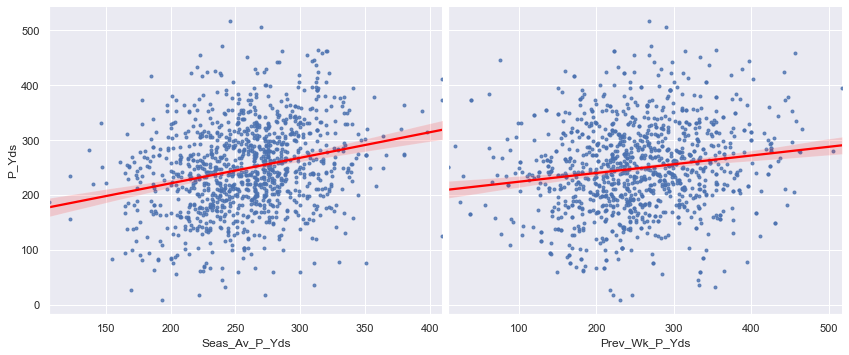

In [18]:
Key_Graphs_3 = sns.pairplot(data=NFL_df,
                  y_vars=['P_Yds'],
                  x_vars=['Seas_Av_P_Yds', 'Prev_Wk_P_Yds'],
                           kind="reg",
                           plot_kws={'line_kws':{'color':'red'}},
                           aspect=1.2,
                           height=5,
                            markers=".")

### Passing yards distribution

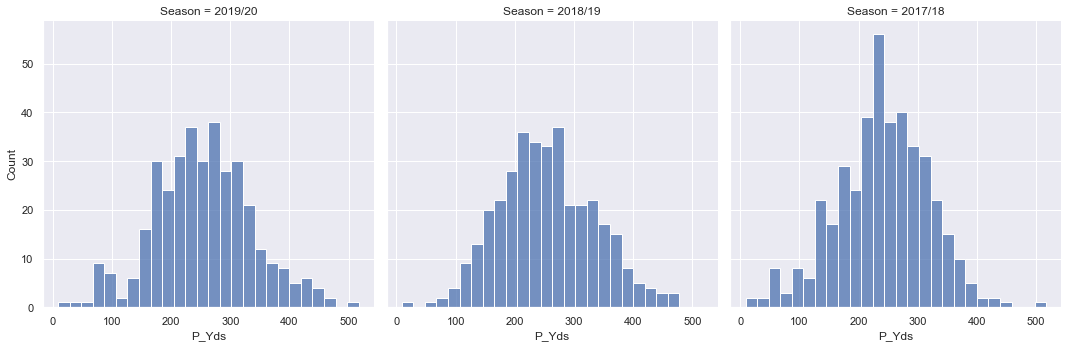

In [19]:
sns.displot(
    data=NFL_df, x="P_Yds", col="Season")

## Regression Analysis

This section contains regression analysis using most of the explanatory variables in the data frame. Some variables are excluded, these are 'Player', 'Date', 'Age', 'Team','Opponent', 'Game_number', 'Under_B_Line' and 'Over_B-Line.

### Initial regression

In [16]:

# Define the predictors
X       = NFL_df[['Prev_Wk_P_Yds','Seas_Av_P_Yds','Prev_Seas_Av_P_Yds','Prev_Seas_Av_P_Atts','Prev_Seas_Comp_Perc','Opp_Prev_Seas_Conc_P_Yds',
                      'Opp_Prev_Seas_Conc_P_Atts','Opp_Prev_Seas_Conc_R_Yds','Opp_Prev_Seas_Conc_R_Atts', 'Opp_Seas_Av_P_Yds',
                      'Opp_Seas_Av_P_Atts', 'Opp_Prev_Wk_P_Yds', 'Prev_Wk_R_Yds', 'Seas_Av_R_Yds', 'Prev_Vs_Opp_P_Yds', 'Prev_Vs_Opp_P_Atts',
                      'Precipitation', 'WindSpeed', 'Temperature',
                      'Outdoors', 'Home']]

# Add a constant to ensure the regression line does not need to pass through the origin
X       = sm.add_constant(X)

# Define the target variable: Passing yards
y       = NFL_df['P_Yds']

In [18]:
# We split the data frame into training and testing samples. We split the sample train = 2/3 test = 1/3. 
# The random_state is set to 42  to ensure we get the same results with each run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model   = sm.OLS(y_train, X_train)
results = model.fit()

# We print the results summary of the training data
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  P_Yds   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     10.61
Date:                Mon, 14 Feb 2022   Prob (F-statistic):           1.29e-30
Time:                        23:14:44   Log-Likelihood:                -4321.9
No. Observations:                 759   AIC:                             8688.
Df Residuals:                     737   BIC:                             8790.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

For the purpose of presentation, we need the entire table to be on one page. The code below saves the regression table as a .png image

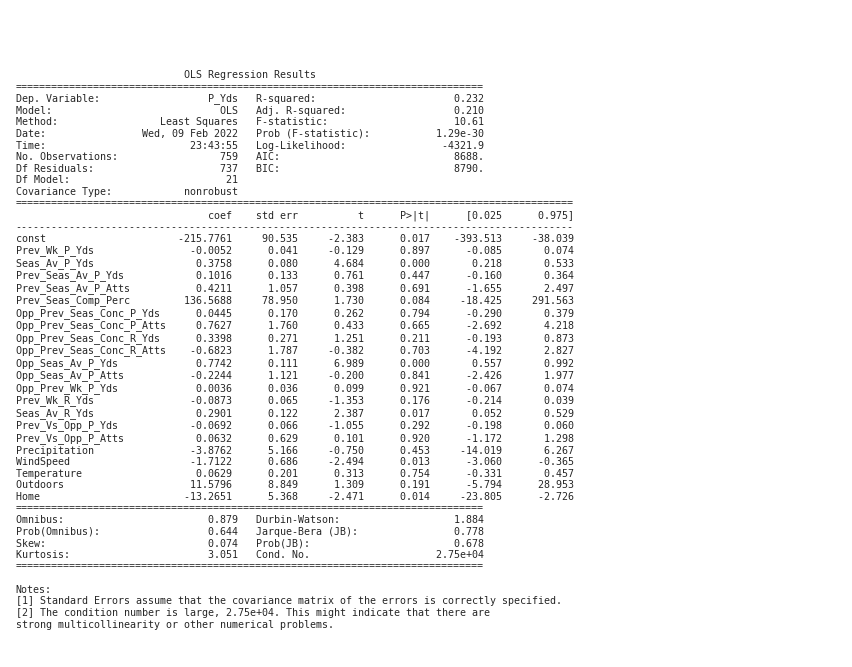

In [24]:
plt.rc('figure', figsize=(12, 10))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(results.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output.png')

Interpreting the regression table. The P values that are smaller than 0.05 indicate that, at a 95% confidence level, the slope of the regression line is not zero, hence there is a significant linear relationship between the dependent and independ variables.

Several values have extremely large P values, suggesting no importance in the regression. 

The key variables seem to be season average passing yards and opponent season average passing yards.


## Comparing the in - sample with the out-of-sample R Squared

In [22]:
# Define and estimate the model
model = LinearRegression().fit(X_train, y_train)
coef  = model.coef_

ypred = model.predict(X_test)

# The coefficient of determination in the training sample
print('Coefficient of determination: %.2f'
      % model.score(X_train, y_train))

# The coefficient of determination in the testing sample
print('Coefficient of determination: %.2f'
      % r2_score(y_test, ypred))


Coefficient of determination: 0.23
Coefficient of determination: 0.19


The model does not fit as well out of sample. For the testing set it is 0.19, a 4 percentage point fall. Whilst this is not a significant absolute fall, it is 17% of the explanation that our model yields

## Shrinkage analysis

We explore whether shrinking or setting some regressor coefficients to zero can can reduce model variance and improve it's predictive ability.

In [23]:
#As shown above, we put the coefficients of determination into a format to compare between methods after shrinkage.
# We also expand to 3 decimal places to allow for comparability
r2_lr = round(r2_score(y_test, ypred),3)

accuracy = {'ols': {'r2 ': r2_lr}}

print('The R Squared value from a regression with no shrinkage is:', r2_lr)
print(accuracy)

The R Squared value from a regression with no shrinkage is: 0.193
{'ols': {'r2 ': 0.193}}


### Estimating the R Squared with a Ridge regression

We begin by estimating a ridge regression with an alpha value of 10.

In [26]:
alpha = 10 #
ridge = Ridge(alpha = alpha, fit_intercept = True) 
ridge.fit(X_train,y_train)

ypred_ridge = ridge.predict(X_test)

r2_ridge = round(r2_score(y_test, ypred_ridge),3)

accuracy['ridge'] = r2_ridge

accuracy

{'ols': {'r2 ': 0.193}, 'ridge': 0.193}

In [25]:
print('The R Squared of the ridge regression with an alpha value of 10 is', r2_ridge)

The R Squared of the ridge regression with an alpha value of 10 is 0.193


The Ridge regression with an alpha of 10 does not improve the regression performance

### Establishing the best penalty term for the ridge regression

In [30]:
alpha_space    = np.linspace(0.01, 0.08, 100) 
param_grid = {'alpha': alpha_space}

ridge_cv  = GridSearchCV(Ridge(), param_grid, cv = 5) 

ridge_cv.fit(X_train, y_train)

ypred_ridge_cv = ridge_cv.predict(X_test)

r2_ridge_cv = round(r2_score(y_test, ypred_ridge_cv),3)

accuracy['ridge cv'] = r2_ridge_cv

accuracy

{'ols': {'r2 ': 0.193}, 'ridge': 0.193, 'ridge cv': 0.194}

In [31]:
print('After an iterative process, we find that the best alpha value for the ridge regression is  \n', ridge_cv.best_estimator_)

After an iterative process, we find that the best alpha value for the ridge regression is  
 Ridge(alpha=0.04040404040404041)


Using a ridge regression only improves R Squared by 0.1 percentage points

### Estimating a Lasso regression

We start by running a lasso regression with an alpha of 10

In [34]:
alpha = 10 
lasso = Lasso(alpha = alpha, fit_intercept = True) # Normalise means that the predictors are 
lasso.fit(X_train,y_train)

ypred_lasso = lasso.predict(X_test)

r2_lasso = round(r2_score(y_test, ypred_lasso), 3)

accuracy['lasso'] = r2_lasso

In [35]:
accuracy = pd.DataFrame(accuracy)
accuracy

,ols,ridge,ridge cv,lasso
r2,0.193,0.193,0.194,0.201


The Lasso regression performs slightly better out-of-samplen than the ridge regression, even with the sub-optimum penalty term. 

### Establishing the best penalty term for the lasso regression

In [39]:
alpha_space    = np.linspace(9.4, 9.6, 100) 
param_grid = {'alpha': alpha_space}

ridge_cv  = GridSearchCV(Ridge(), param_grid, cv = 5)

lasso_cv  = GridSearchCV(Lasso(), param_grid, cv = 5) 

lasso_cv.fit(X_train, y_train)

ypred_lasso_cv = lasso_cv.predict(X_test)

r2_lasso_cv = round(r2_score(y_test, ypred_lasso_cv), 3)

accuracy['lasso cv'] = r2_lasso_cv

accuracy

,ols,ridge,ridge cv,lasso,lasso cv
r2,0.193,0.193,0.194,0.201,0.201


In [40]:
print('We find that the best alpha value for the Lasso regression is  \n', lasso_cv.best_estimator_)

We find that the best alpha value for the Lasso regression is  
 Lasso(alpha=9.517171717171717)


Optimising the value of alpha does not improve the Lasso regression

# Estimating the Lasso regression with alpha = 9.52

The optimum alpha will be different for the training set and test set

In [52]:
lasso = Lasso(alpha= 9.52)
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
#coeff_used = np.sum(lasso.coef_!=0)
lasso_coeff = pd.DataFrame()
lasso_coeff["Columns"] = X_train.columns
lasso_coeff['Coefficient Estimate'] = pd.Series(lasso.coef_)
 
print(lasso_coeff)

                      Columns  Coefficient Estimate
0                       const              0.000000
1               Prev_Wk_P_Yds             -0.001208
2               Seas_Av_P_Yds              0.364117
3          Prev_Seas_Av_P_Yds              0.221380
4         Prev_Seas_Av_P_Atts             -0.000000
5         Prev_Seas_Comp_Perc              0.000000
6    Opp_Prev_Seas_Conc_P_Yds              0.079602
7   Opp_Prev_Seas_Conc_P_Atts              0.000000
8    Opp_Prev_Seas_Conc_R_Yds              0.223780
9   Opp_Prev_Seas_Conc_R_Atts             -0.000000
10          Opp_Seas_Av_P_Yds              0.756191
11         Opp_Seas_Av_P_Atts              0.000000
12          Opp_Prev_Wk_P_Yds              0.002192
13              Prev_Wk_R_Yds             -0.086544
14              Seas_Av_R_Yds              0.294595
15          Prev_Vs_Opp_P_Yds             -0.068650
16         Prev_Vs_Opp_P_Atts              0.000000
17              Precipitation             -0.000000
18          

In [46]:
print ("R squared training set:", round(train_score, 3))
print ("R squared test set: ", round(test_score, 3))

R squared training set: 0.219
R squared test set:  0.201


In [47]:
# dense np.array
print(lasso.coef_)

[ 0.         -0.00120757  0.3641167   0.22138017 -0.          0.
  0.07960187  0.          0.22377976 -0.          0.75619093  0.
  0.00219211 -0.08654358  0.29459535 -0.06864953  0.         -0.
 -0.95159537  0.          0.         -0.        ]


In [48]:
coefficient_vector = np.abs(lasso.coef_)

In [49]:
np.array(X.columns)[coefficient_vector > 0]

array(['Prev_Wk_P_Yds', 'Seas_Av_P_Yds', 'Prev_Seas_Av_P_Yds',
       'Opp_Prev_Seas_Conc_P_Yds', 'Opp_Prev_Seas_Conc_R_Yds',
       'Opp_Seas_Av_P_Yds', 'Opp_Prev_Wk_P_Yds', 'Prev_Wk_R_Yds',
       'Seas_Av_R_Yds', 'Prev_Vs_Opp_P_Yds', 'WindSpeed'], dtype=object)

The column names in the array above have coefficients __greater than zero__ in the lasso regression with cross-validated alpha

In [50]:
np.array(X.columns)[coefficient_vector == 0]

array(['const', 'Prev_Seas_Av_P_Atts', 'Prev_Seas_Comp_Perc',
       'Opp_Prev_Seas_Conc_P_Atts', 'Opp_Prev_Seas_Conc_R_Atts',
       'Opp_Seas_Av_P_Atts', 'Prev_Vs_Opp_P_Atts', 'Precipitation',
       'Temperature', 'Outdoors', 'Home'], dtype=object)

The column names in the array above have coefficients set to __exactly zero__ in the lasso regression with cross-validated alpha

### Next steps

The next script will run through the applications of machine learning methods to whether a player threw over/under a betting line